# Problem Description
Describe model and scheme here...

In [1]:
import matplotlib
matplotlib.rc( 'image', cmap='jet' )
import math

from ufl import *
from dune.ufl import Space, Constant

import dune.fem as fem
import dune.create as create
from dune.generator import algorithm
from dune.common import FieldVector
from dune.grid import cartesianDomain, Marker, gridFunction
from dune.fem.function import levelFunction, integrate
from dune.plotting import plotPointData as plot

from limit import createOrderRedcution, createLimiter

Some parameters

In [2]:
maxLevel  = 3
maxOrder  = 3
dt        = 5.
endTime   = 800.
coupled   = True
tolerance = 3e-2
penalty   = 5 * (maxOrder * ( maxOrder + 1 ))
newtonParameters = {"tolerance": tolerance,
                    "verbose": "true", "linear.verbose": "false",
                    "linabstol": 1e-8, "reduction": 1e-8}

# Defining the model
using a Broks Corey pressure law

In [3]:
def brooksCorey(P,s_n):
    s_w = 1-s_n
    s_we = (s_w-P.s_wr)/(1.-P.s_wr-P.s_nr)
    s_ne = (s_n-P.s_nr)/(1.-P.s_wr-P.s_nr)
    if P.useCutOff:
        cutOff = lambda a: min_value(max_value(a,0.00001),0.99999)
        s_we = cutOff(s_we)
        s_ne = cutOff(s_ne)
    kr_w = s_we**((2.+3.*P.theta)/P.theta)
    kr_n = s_ne**2*(1.-s_we**((2.+P.theta)/P.theta))
    p_c  = P.pd*s_we**(-1./P.theta)
    dp_c = P.pd * (-1./P.theta) * s_we**(-1./P.theta-1.) * (-1./(1.-P.s_wr-P.s_nr))
    l_n  = kr_n / P.mu_n
    l_w  = kr_w / P.mu_w
    return p_c,dp_c,l_n,l_w

Constants and domain description for anisotropic lens test

In [4]:
class AnisotropicLens:
    dimWorld = 2
    domain   = cartesianDomain([0,0.39],[0.9,0.65],[15,4])
    x        = SpatialCoordinate(triangle)

    g     = [0,]*dimWorld ; g[dimWorld-1] = -9.810 # [m/s^2]
    g     = as_vector(g)
    r_w   = 1000.  # [Kg/m^3]
    mu_w  = 1.e-3  # [Kg/m s]
    r_n   = 1460.  # [Kg/m^3]
    mu_n  = 9.e-4  # [Kg/m s]

    lens = lambda x,a,b: (a-b)*                (conditional(abs(x[1]-0.49)<0.03,1.,0.)*                 conditional(abs(x[0]-0.45)<0.11,1.,0.))                + b

    p_c = brooksCorey

    Kdiag = lens(x, 6.64*1e-14, 1e-10) # [m^2]
    Koff  = lens(x, 0,-5e-11)          # [m^2]
    K     = as_matrix( [[Kdiag,Koff],[Koff,Kdiag]] )

    Phi   = lens(x, 0.39, 0.40)             # [-]
    s_wr  = lens(x, 0.10, 0.12)             # [-]
    s_nr  = lens(x, 0.00, 0.00)             # [-]
    theta = lens(x, 2.00, 2.70)             # [-]
    pd    = lens(x, 5000., 755.)            # [Pa]

    #### initial conditions
    p_w0 = (0.65-x[1])*9810.       # hydrostatic pressure
    s_n0 = 0                       # fully saturated
    # boundary conditions
    inflow = conditional(abs(x[0]-0.45)<0.06,1.,0.)*             conditional(abs(x[1]-0.65)<1e-8,1.,0.)
    J_n  = -5.137*1e-5
    J_w  = 1e-20
    dirichlet = conditional(abs(x[0])<1e-8,1.,0.) +                conditional(abs(x[0]-0.9)<1e-8,1.,0.)
    p_wD = p_w0
    s_nD = s_n0

    q_n  = 0
    q_w  = 0

    useCutOff = False

P = AnisotropicLens()

Setup grid, discrete spaces and functions

In [5]:
grid = create.view("adaptive", "ALUCube", P.domain, dimgrid=2)

if coupled:
    spc          = create.space("dglegendrehp", grid, dimRange=2, order=maxOrder)
else:
    spc1         = create.space("dglegendrehp", grid, dimRange=1, order=maxOrder)
    spc          = create.space("product", spc1,spc1, components=["p","s"] )

solution     = spc.interpolate([0,0], name="solution")
solution_old = spc.interpolate([0,0], name="solution_old")
sol_pm1      = spc.interpolate([0,0], name="sol_pm1")
intermediate = spc.interpolate([0,0], name="iterate")
persistentDF = [solution,solution_old,intermediate]

fvspc        = create.space("finitevolume", grid, dimRange=1, storage="fem")
estimate     = fvspc.interpolate([0], name="estimate")
estimate_pm1 = fvspc.interpolate([0], name="estimate-pm1")

In [6]:
uflSpace = Space((P.dimWorld,P.dimWorld),2)
u        = TrialFunction(uflSpace)
v        = TestFunction(uflSpace)
cell     = uflSpace.cell()
x        = SpatialCoordinate(cell)
tau      = Constant(dt, name="timeStep")
beta     = Constant(penalty, name="penalty")

p_w  = u[0]
s_n  = u[1]

p_c,dp_c,l_n,l_w = P.p_c(s_n=intermediate[1])

Bulk terms

In [7]:
dBulk_p  = P.K*( (l_n+l_w)*grad(p_w) + l_n*dp_c*grad(s_n) )
dBulk_p += -P.K*( (P.r_n*l_n+P.r_w*l_w)*P.g )
bulk_p   = -(P.q_w+P.q_n)
dBulk_s  = P.K*l_n*dp_c*grad(s_n)
dBulk_s += P.K*l_n*(grad(p_w)-P.r_n*P.g)
bulk_s   = -P.q_n

Boundary and initial conditions

In [8]:
p_D, s_D = P.p_wD, P.s_nD,
p_N, s_N = P.J_w+P.J_n, P.J_n
p_0, s_0 = P.p_w0, P.s_n0

Bulk integrals

In [9]:
form_p = ( inner(dBulk_p,grad(v[0])) + bulk_p*v[0] ) * dx
form_s = ( inner(dBulk_s,grad(v[1])) + bulk_s*v[1] ) * dx

Boundary fluxes

In [10]:
form_p += p_N * v[0] * P.inflow * ds
form_s += s_N * v[1] * P.inflow * ds

DG terms

In [11]:
def sMax(a): return max_value(a('+'), a('-'))
n         = FacetNormal(cell)
hT        = MaxCellEdgeLength(cell)
he        = avg( CellVolume(cell) ) / FacetArea(cell)
heBnd     = CellVolume(cell) / FacetArea(cell)
k         = dot(P.K*n,n)
lambdaMax = k('+')*k('-')/avg(k)
def wavg(z): return (k('-')*z('+')+k('+')*z('-'))/(k('+')+k('-'))

Penalty terms (including dirichlet boundary treatment)

In [12]:
p_c0,dp_c0,l_n0,l_w0 = P.p_c(0.5)
penalty_p = [beta*lambdaMax*sMax(l_n0+l_w0),
             beta*k*(l_n0+l_w0)]
penalty_s = [beta*lambdaMax*sMax(l_n0*dp_c0),
             beta*k*(l_n0*dp_c0)]
form_p += penalty_p[0]/he * jump(u[0])*jump(v[0]) * dS
form_s += penalty_s[0]/he * jump(u[1])*jump(v[1]) * dS
form_p += penalty_p[1]/heBnd * (u[0]-p_D) * v[0] * P.dirichlet * ds
form_s += penalty_s[1]/heBnd * (u[1]-s_D) * v[1] * P.dirichlet * ds

Consistency terms

In [13]:
form_p -= inner(wavg(dBulk_p),n('+')) * jump(v[0]) * dS
form_s -= inner(wavg(dBulk_s),n('+')) * jump(v[1]) * dS
form_p -= inner(dBulk_p,n) * v[0] * P.dirichlet * ds
form_s -= inner(dBulk_s,n) * v[1] * P.dirichlet * ds

# Time discretization

In [14]:
form_s = P.Phi*(u[1]-solution_old[1])*v[1] * dx + tau*form_s

# Stabilization (Limiter)

In [15]:
limiter = createLimiter( spc, limiter="scaling" )
tmp = solution.copy()
def limit(target):
    tmp.assign(target)
    limiter(tmp,target)

Time stepping
Converting UFL forms to scheme

In [16]:
if coupled:
    form = form_s + form_p
    tpModel = create.model( "integrands", grid, form == 0)
    # tpModel.penalty  = penalty
    # tpModel.timeStep = dt
    scheme = create.scheme("galerkin", tpModel, spc, ("suitesparse","umfpack"),
                     parameters={"newton." + k: v for k, v in newtonParameters.items()})
else:
    uflSpace1 = Space((P.dimWorld,P.dimWorld),1)
    u1        = TrialFunction(uflSpace1)
    v1        = TestFunction(uflSpace1)
    form_p = replace(form_p, { u:as_vector([u1[0],intermediate.s[0]]),
                             v:as_vector([v1[0],0.]) } )
    form_s = replace(form_s, { u:as_vector([solution[0],u1[0]]),
                             intermediate:as_vector([solution[0],intermediate[1]]),
                             v:as_vector([0.,v1[0]]) } )
    form = [form_p,form_s]
    tpModel = [create.model( "integrands", grid, form[0] == 0),
               create.model( "integrands", grid, form[1] == 0)]
    # tpModel[0].penalty  = penalty
    # tpModel[1].penalty  = penalty
    # tpModel[1].timeStep = dt
    scheme = [create.scheme("galerkin", m, s, ("suitesparse","umfpack"),
                     parameters={"newton." + k: v for k, v in newtonParameters.items()})
                for m,s in zip(tpModel,spc.components)]

Stopping condition for iterative approaches

In [17]:
def errorMeasure(w,dw):
    rel = integrate(grid, [w[1]**2,dw[1]**2], 5)
    return math.sqrt(rel[1]) < tolerance * math.sqrt(rel[0])

# Iterative schemes (iterative or impes-iterative)

In [18]:
def step():
    n = 0
    solution_old.assign(solution)
    while True:
        intermediate.assign(solution)
        if coupled:
            scheme.solve(target=solution)
        else:
            scheme[0].solve(target=solution.p)
            scheme[1].solve(target=solution.s)
        limit(solution)
        n += 1
        # print("step",n,flush=True)
        if errorMeasure(solution,solution-intermediate) or n==20:
            break

# HP Adpativity

Setting up residual indicator

In [19]:
uflSpace0 = Space((P.dimWorld,P.dimWorld),1)
v0        = TestFunction(uflSpace0)

Rvol = P.Phi*(u[1]-solution_old[1])/tau - div(dBulk_s) - bulk_s
estimator = hT**2 * Rvol**2 * v0[0] * dx +      he * inner(jump(dBulk_s), n('+'))**2 * avg(v0[0]) * dS +      heBnd * (s_N + inner(dBulk_s,n))**2 * v0[0] * P.inflow * ds +      penalty_s[0]**2/he * jump(u[1])**2 * avg(v0[0]) * dS +      penalty_s[1]**2/heBnd * (s_D - u[1])**2 * v0[0] * P.dirichlet * ds
estimator = replace(estimator, {intermediate:u})

estimatorModel = create.model("integrands", grid, estimator == 0)
# estimatorModel.timeStep = dt
# estimatorModel.penalty  = penalty
estimator = create.operator("galerkin", estimatorModel, spc, fvspc)

# Marker for grid adaptivity (h)

In [20]:
hTol = 1e-16                           # changed later
def markh(element):
    center = element.geometry.referenceElement.center
    eta    = estimate.localFunction(element).evaluate(center)[0]
    if eta > hTol and element.level < maxLevel:
      return Marker.refine
    elif eta < 0.01*hTol:
      return Marker.coarsen
    else:
      return Marker.keep

# Marker for space adaptivity (p)

In [21]:
pTol = 1e-16
def markp(element):
    center = element.geometry.referenceElement.center
    r      = estimate.localFunction(element).evaluate(center)[0]
    r_p1   = estimate_pm1.localFunction(element).evaluate(center)[0]
    eta = abs(r-r_p1)
    polorder = spc.localOrder(element)
    if eta < pTol:
        return polorder-1 if polorder > 1 else polorder
    elif eta > 100.*pTol:
        return polorder+1 if polorder < maxOrder else polorder
    else:
        return polorder

Operator for projecting into space with a reduced order on every element

In [22]:
orderreduce  = createOrderRedcution( spc )

# Main program

Pre adapt the grid

In [23]:
hgrid = grid.hierarchicalGrid
hgrid.globalRefine(1)
for i in range(maxLevel):
    print("pre adaptive (",i,"): ",grid.size(0),end="\n")
    solution.interpolate( as_vector([p_0,s_0]) )
    limit(solution)
    step()
    estimator(solution, estimate)
    hgrid.mark(markh)
    fem.adapt(persistentDF)

print("final pre adaptive (",i,"): ",dt,grid.size(0),end="\n")

pre adaptive ( 0 ):  240


pre adaptive ( 1 ):  213


pre adaptive ( 2 ):  363


final pre adaptive ( 2 ):  5.0 273


Define the constant for the h adaptivity

In [24]:
solution.interpolate( as_vector([p_0,s_0]) )
limit(solution)
estimator(solution, estimate)
timeTol = sum(estimate.dofVector) / endTime
print('Using timeTol = ',timeTol, end='\n')

Using timeTol =  3.2161312218750177e-15


Time loop

5.0 240 0.0 5.890350223214318e-17 # timestep


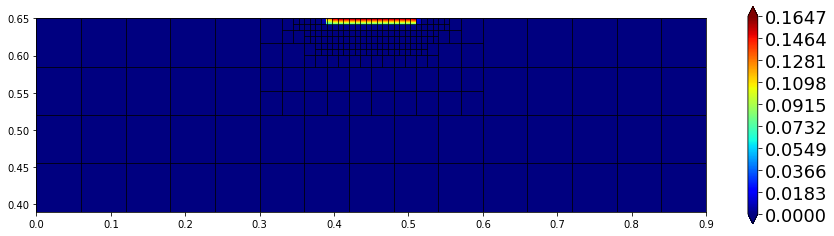

100.0 357 0.0 4.504385464810949e-17 # timestep


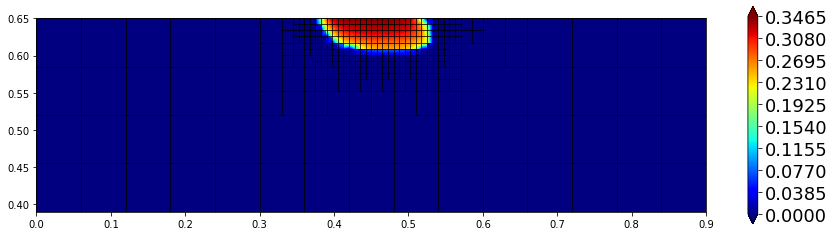

200.0 477 0.0 3.4360376302083523e-17 # timestep


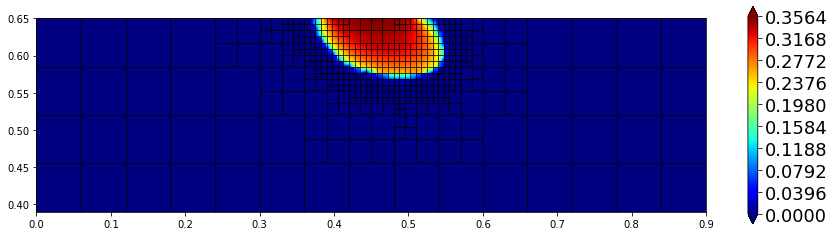

300.0 582 0.0 2.748830104166682e-17 # timestep


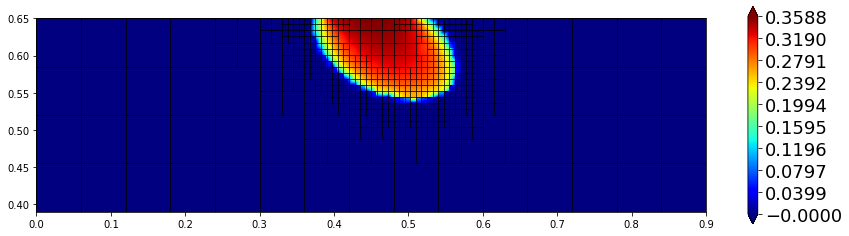

400.0 615 0.0 2.5770282226562644e-17 # timestep


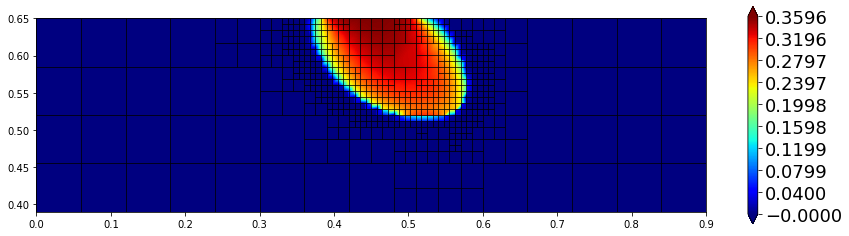

500.0 714 0.0 2.242769331851477e-17 # timestep


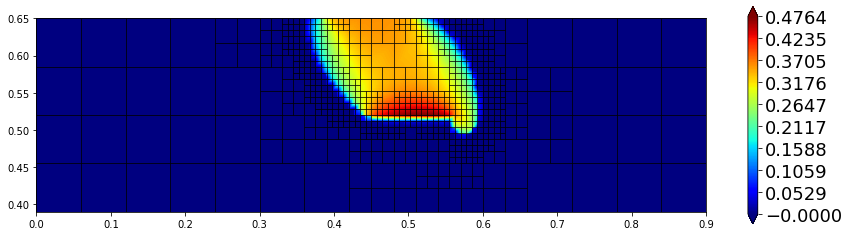

600.0 813 0.0 1.949170437500011e-17 # timestep


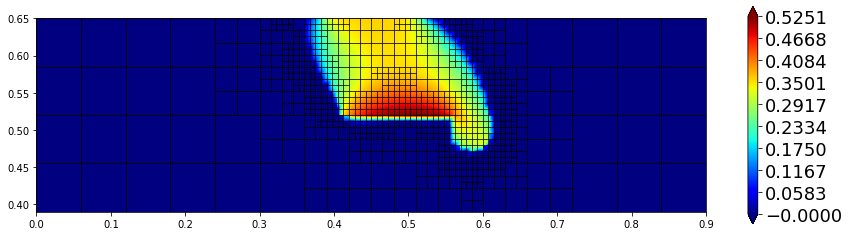

700.0 924 0.0 1.7690490769389536e-17 # timestep


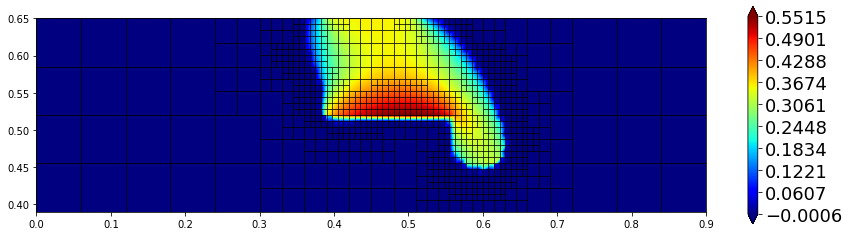

800.0 1011 0.0 1.6096752862237327e-17 # timestep


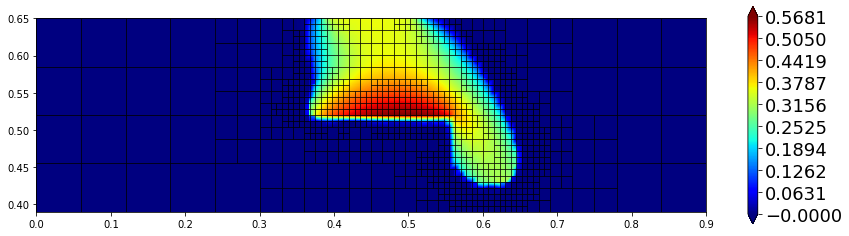

In [25]:
t = 0
saveStep = 0
while t < endTime:
    step()

    # h adaptivity
    hTol = timeTol * dt / grid.size(0)
    estimator(solution, estimate)
    hgrid.mark(markh)
    fem.adapt(persistentDF)

    # p adaptivity
    estimator(solution, estimate)
    orderreduce(solution,sol_pm1)
    estimator(sol_pm1, estimate_pm1)
    fem.spaceAdapt(spc, markp, persistentDF)
    t += dt

    if t>=saveStep:
        print(t,grid.size(0),sum(estimate.dofVector),hTol,"# timestep",flush=True)
        plot(solution[1],figsize=(15,4))
        saveStep += 100

Postprocessing
Show solution along a given line

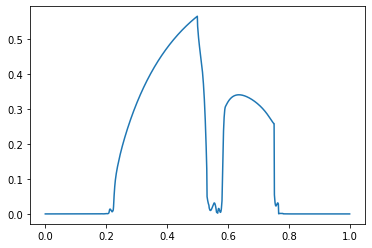

In [26]:
x0 = FieldVector([0.25,  0.65])
x1 = FieldVector([0.775, 0.39])
p,v = algorithm.run('sample', 'utility.hh', solution, x0, x1, 1000)

from matplotlib import pyplot
import numpy
x = numpy.zeros(len(p))
y = numpy.zeros(len(p))
l = (x1-x0).two_norm
for i in range(len(x)):
    x[i] = (p[i]-x0).two_norm / l
    y[i] = v[i][1]
pyplot.plot(x,y)
pyplot.show()

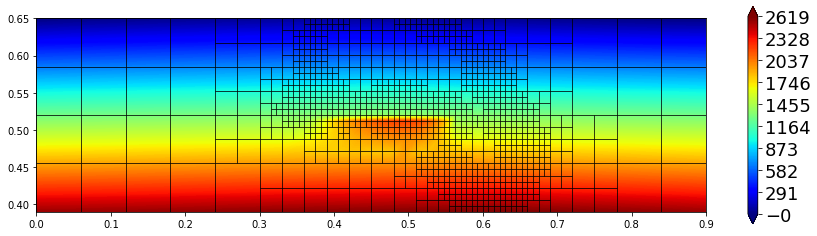

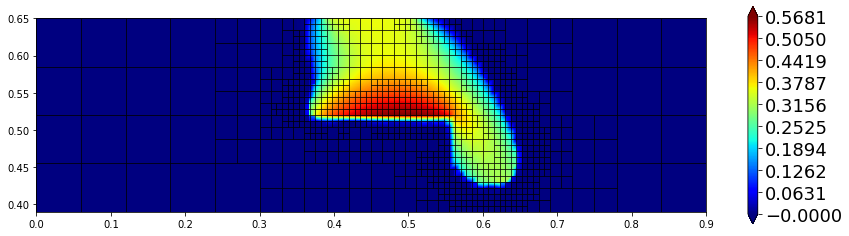

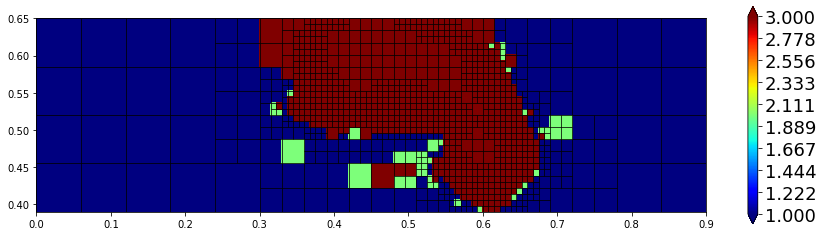

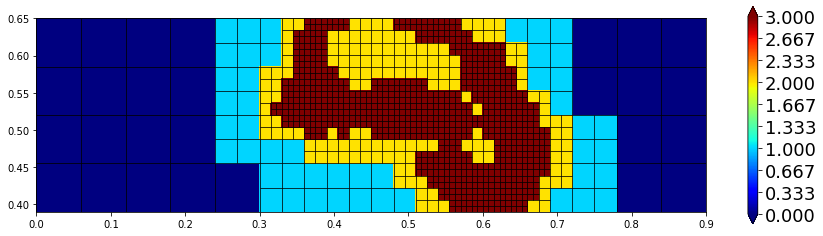

In [27]:
from dune.grid import gridFunction
from dune.fem.function import levelFunction
@gridFunction(grid,name="polOrder")
def polOrder(e,x):
    return [spc.localOrder(e)]
plot(solution[0],figsize=(15,4))
plot(solution[1],figsize=(15,4))
plot(polOrder,figsize=(15,4))
plot(levelFunction(grid),figsize=(15,4))